In [6]:
import pandas as pd
from os.path import join
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import yaml
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score

%matplotlib inline

In [66]:
perp_fp_fmt = '/fs/cbcb-lab/rob/students/noor/shoal_proj/seqc/perplexity/vbprior=1e0/c={weight}/{sample}/{fold}/perplexity.yml'
# perp_fp_fmt = '../output/seqc-bgi/eval/perplexity/BGI_FC1_{cond}_{rep}/vbprior={vb_prior}/{fold}/perplexity.yml'

tpm_shoal_fmt = join("/fs/cbcb-lab/rob/students/noor/shoal_proj/seqc/shoal", "vbprior=1e0", "{fname}", "{fold}", "{sample}_c={w}_adapt.sf")
tpm_sal_fmt = join("/fs/cbcb-lab/rob/students/jason/rna-perplexity-experiments/output/seqc-bgi/quants", "BGI_FC1_{cond}_{rep}", "vbprior=1e0", "{fold}", "quant.sf")
SAMPLES = [
    'BGI_FC1_A_1',
    'BGI_FC1_A_2',
    'BGI_FC1_A_3',
    'BGI_FC1_A_4',
    'BGI_FC1_B_1',
    'BGI_FC1_B_2',
    'BGI_FC1_B_3',
    'BGI_FC1_B_4',
    'BGI_FC1_C_1',
    'BGI_FC1_C_2',
    'BGI_FC1_C_3',
    'BGI_FC1_C_4' ]

best_weights = [1000, 1000, 100, 100, 100, 100, 10, 100, 1000, 1000, 100, 100]
fnames = ["A_B"]*12
fnames[8:12] = ["C"]*4

#     'BGI_FC1_D_1',
#     'BGI_FC1_D_2',
#     'BGI_FC1_D_3',
#     'BGI_FC1_D_4' ]

In [78]:
CONDS = ['A', 'B', 'C', 'D']
CONDS = ['A', 'B', 'C']
REPLICATES = [1, 2, 3, 4]
WEIGHTS = '1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000 100000'.split()
SHOAL_QUANTS = {}
SAL_QUANTS = {}

# for w in WEIGHTS:
#     SALMON_QUANTS[w] = {}
#     for fold in range (1, 6):
#         SALMON_QUANTS[w][fold] = {}
#         for c in CONDS:
#             SALMON_QUANTS[w][fold][c] = []
#             for sample in SAMPLES:
#                 if '_{}_'.format(c) in sample:
#                     df_fp = tpm_fmt.format(w=w, sample=sample, fold=fold)
#                     SALMON_QUANTS[w][fold][c].append(pd.read_csv(df_fp, sep='\t'))

for fold in range (1, 6):
    SAL_QUANTS[fold] = {}
    for c in CONDS:
        SAL_QUANTS[fold][c] = []
        for rep in REPLICATES:
                df_fp = tpm_sal_fmt.format(cond=c, rep=str(rep), fold=fold)
                SAL_QUANTS[fold][c].append(pd.read_csv(df_fp, sep='\t'))

for fold in range (1, 6):
    SHOAL_QUANTS[fold] = {}
    for c in CONDS:
        SHOAL_QUANTS[fold][c] = []
        for (i,sample) in enumerate(SAMPLES):
            if '_{}_'.format(c) in sample:
                df_fp = tpm_shoal_fmt.format(w=best_weights[i], sample=sample, fold=fold, fname=fnames[i])
                SHOAL_QUANTS[fold][c].append(pd.read_csv(df_fp, sep='\t'))
                                 

In [11]:
# from scipy.spatial.distance import pdist, cdist, squareform
# from scipy import stats

def arr_spearman(A, B):
    return spearmanr(A, B).correlation

In [75]:
SAL_QUANTS[1]['C'][2][30:40]

,Name,Length,EffectiveLength,TPM,NumReads
30,ENST00000430425.1,17,17.000,0.000000,0.000
31,ENST00000454691.1,18,18.000,0.000000,0.000
32,ENST00000390590.1,31,31.000,0.000000,0.000
33,ENST00000390340.2,463,286.621,0.000000,0.000
34,ENST00000390341.2,512,335.456,0.000000,0.000
35,ENST00000444775.2,1735,1558.295,0.000000,0.000
36,ENST00000390343.2,468,291.603,0.000000,0.000
37,ENST00000390344.2,552,375.400,0.000000,0.000
38,ENST00000390345.2,688,511.333,0.119001,1.393
39,ENST00000390346.2,537,360.420,0.121226,1.000


# Average Intersample correlations at various nucleotide prior settings

In [55]:
SHOAL_QUANTS[fold]['B'][0].Name == SHOAL_QUANTS[fold]['A'][1].Name

0         True
1         True
2         True
3         True
4         True
          ... 
167263    True
167264    True
167265    True
167266    True
167267    True
Name: Name, Length: 167268, dtype: bool

# Concordance with mixing proportions

In [79]:
def concordance_shoal(folds=5, comp_fn=arr_spearman):

    C_scores = []

    for fold in range(1, folds+1):
        C_PREDS = []
        D_PREDS = []
        for A_df in SHOAL_QUANTS[fold]['A']:
            for B_df in SHOAL_QUANTS[fold]['B']:
                C_PREDS.append(0.75 * A_df.TPM.values + 0.25 * B_df.TPM.values)
#                 D_PREDS.append(0.25 * A_df.TPM.values + 0.75 * B_df.TPM.values)

        for true_C_df in SHOAL_QUANTS[fold]['C']:
            for pred_C_tpms in C_PREDS:
                C_scores.append(comp_fn(true_C_df.TPM.values, pred_C_tpms))
                
#         for true_D_df in SALMON_QUANTS[vb_prior][fold]['D']:
#             for pred_D_tpms in D_PREDS:
#                     D_scores.append(comp_fn(true_D_df.TPM.values, pred_D_tpms))

    return dict(C=C_scores, method=["Shoal"]*len(C_scores))
#     return dict(C=C_scores, D=D_scores, vb_prior=[vb_prior]*len(D_scores))

def concordance_sal(folds=5, comp_fn=arr_spearman):

    C_scores = []

    for fold in range(1, folds+1):
        C_PREDS = []
        D_PREDS = []
        for A_df in SAL_QUANTS[fold]['A']:
            for B_df in SAL_QUANTS[fold]['B']:
                C_PREDS.append(0.75 * A_df.TPM.values + 0.25 * B_df.TPM.values)
#                 D_PREDS.append(0.25 * A_df.TPM.values + 0.75 * B_df.TPM.values)

        for true_C_df in SAL_QUANTS[fold]['C']:
            for pred_C_tpms in C_PREDS:
                C_scores.append(comp_fn(true_C_df.TPM.values, pred_C_tpms))
                
#         for true_D_df in SALMON_QUANTS[vb_prior][fold]['D']:
#             for pred_D_tpms in D_PREDS:
#                     D_scores.append(comp_fn(true_D_df.TPM.values, pred_D_tpms))

    return dict(C=C_scores, method=["Sal"]*len(C_scores))
#     return dict(C=C_scores, D=D_scores, vb_prior=[vb_prior]*len(D_scores))

# def concordance(vb_prior, folds=5, comp_fn=arr_spearman):

#     C_scores = []
#     D_scores = []

#     for fold in range(1, folds+1):
#         C_PREDS = []
#         D_PREDS = []
#         for A_df in SALMON_QUANTS[vb_prior][fold]['A']:
#             for B_df in SALMON_QUANTS[vb_prior][fold]['B']:
#                 C_PREDS.append(0.75 * A_df.TPM.values + 0.25 * B_df.TPM.values)
#                 D_PREDS.append(0.25 * A_df.TPM.values + 0.75 * B_df.TPM.values)

#         for true_C_df in SALMON_QUANTS[vb_prior][fold]['C']:
#             for pred_C_tpms in C_PREDS:
#                 C_scores.append(comp_fn(true_C_df.TPM.values, pred_C_tpms))
                
#         for true_D_df in SALMON_QUANTS[vb_prior][fold]['D']:
#             for pred_D_tpms in D_PREDS:
#                     D_scores.append(comp_fn(true_D_df.TPM.values, pred_D_tpms))

#     return dict(C=C_scores, D=D_scores, vb_prior=[vb_prior]*len(D_scores))

In [81]:
shoal_con = concordance_shoal()
sal_con = concordance_sal()

In [86]:

res_df = pd.DataFrame()
res_df = pd.DataFrame(shoal_con)
res_df = res_df.append(pd.DataFrame(sal_con))
# for vbprior in VB_PRIORS:
#     vbprior_df = pd.DataFrame(concordance(vbprior))
#     res_df = res_df.append(vbprior_df)
    

In [87]:
res_df

,C,method
0,0.931580,Shoal
1,0.931672,Shoal
2,0.927626,Shoal
3,0.931462,Shoal
4,0.931712,Shoal
...,...,...
315,0.915585,Sal
316,0.918399,Sal
317,0.917970,Sal
318,0.917450,Sal


In [11]:
64 * len(VB_PRIORS) * 5

2560

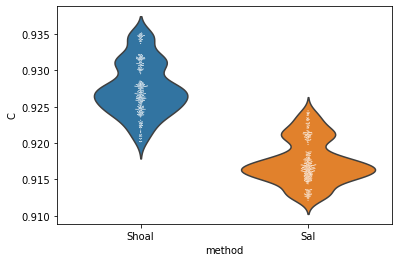

In [88]:
ax = sns.violinplot(x="method", y="C", data=res_df, inner=None)
ax = sns.swarmplot(x="method", y="C", data=res_df,
                   color="white", edgecolor="gray", dodge=True, s=1)

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 30.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


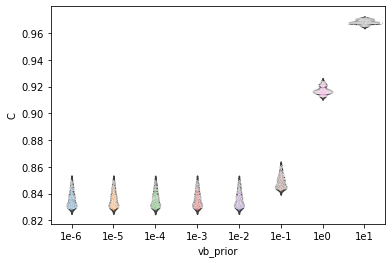

In [13]:
ax = sns.violinplot(x="vb_prior", y="C", data=res_df, inner=None)
ax = sns.swarmplot(x="vb_prior", y="C", data=res_df,
                   color="white", edgecolor="gray", dodge=True, s=1)

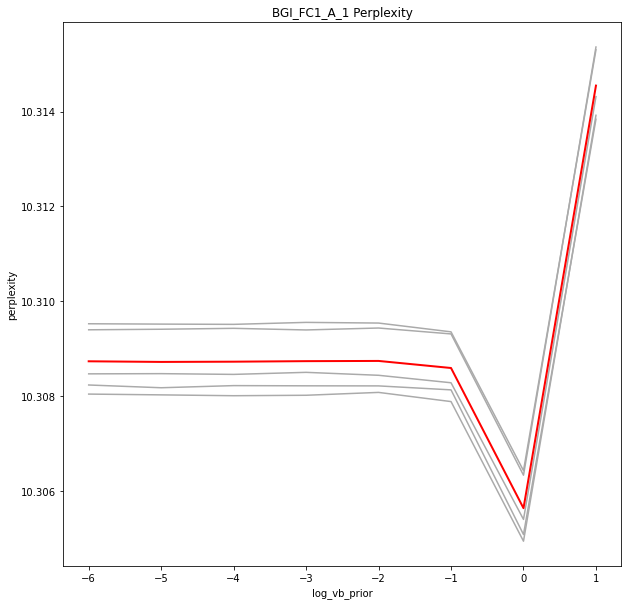

<AxesSubplot:title={'center':'BGI_FC1_A_1 Perplexity'}, xlabel='log_vb_prior', ylabel='perplexity'>

In [25]:
def perplexity_plot(sample, vb_priors, folds):
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        #folds_rhos = []
        for fold in range(1, folds + 1):
            with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior, fold=fold), 'r') as f:
                perp_result = yaml.safe_load(f)
            #folds_rhos.append(rho)
            _vb_prior = float(vb_prior)
            df = df.append(dict(perplexity=-perp_result['smoothed_perplexity'],
                                vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior),
                                fold=fold), 
                           ignore_index=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(sample + " Perplexity")
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, units="fold", estimator=None, color='#AAAAAA')
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, err_style=None, lw=2, color="red")

    plt.show()
    
    
    return ax

perplexity_plot(SAMPLES[0], VB_PRIORS, 5)

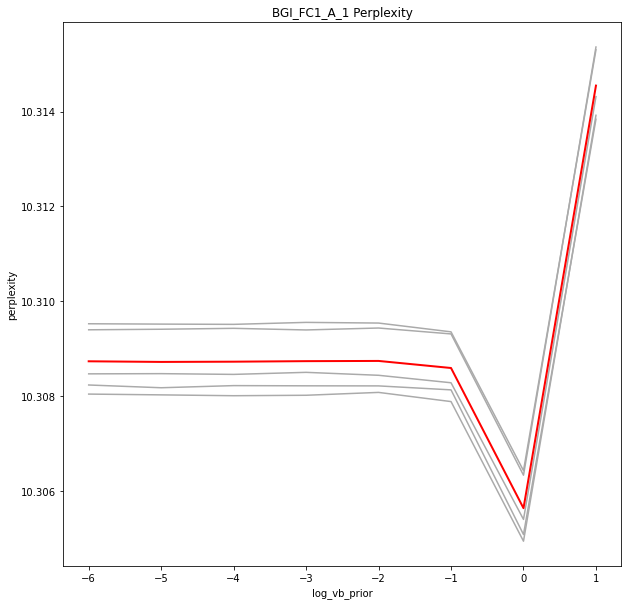

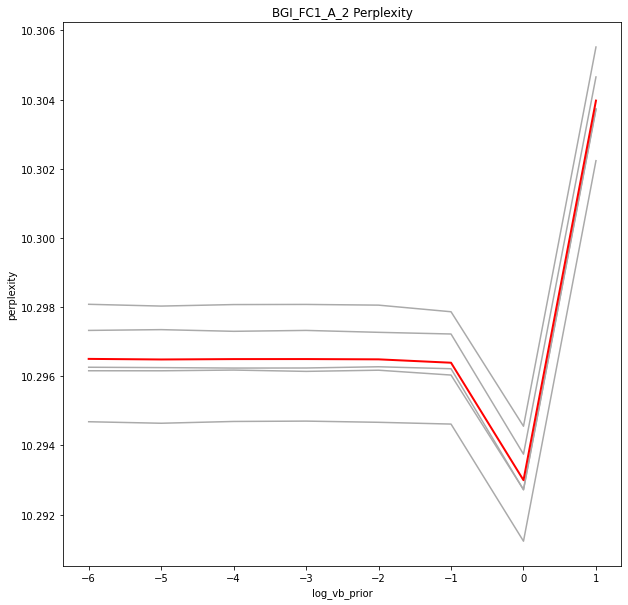

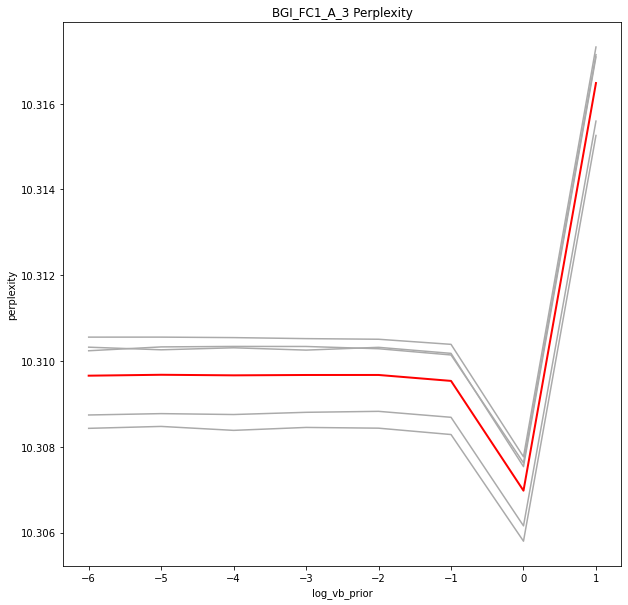

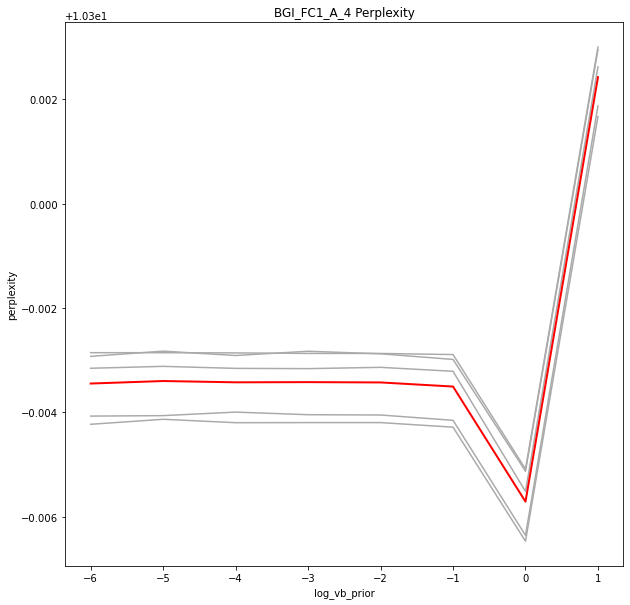

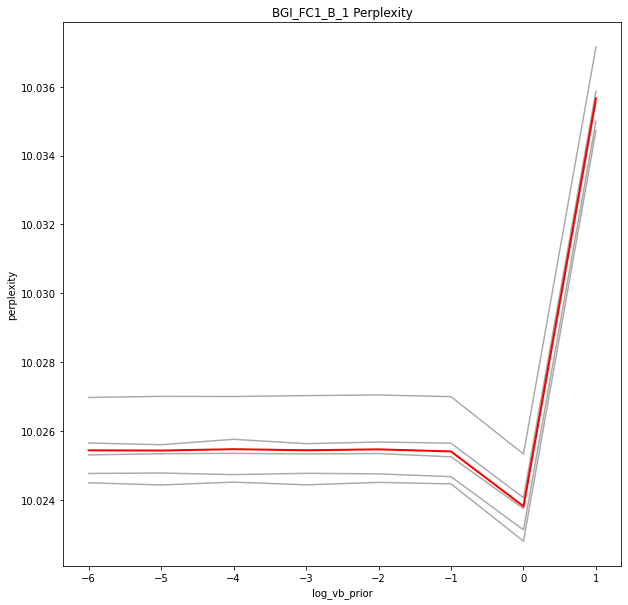

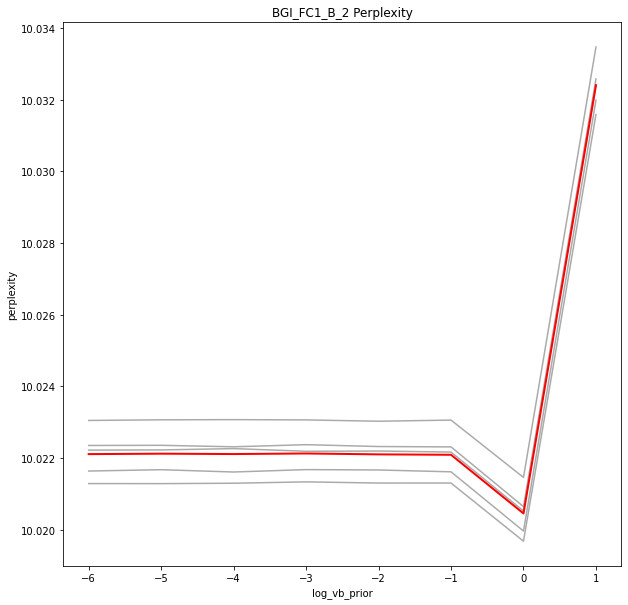

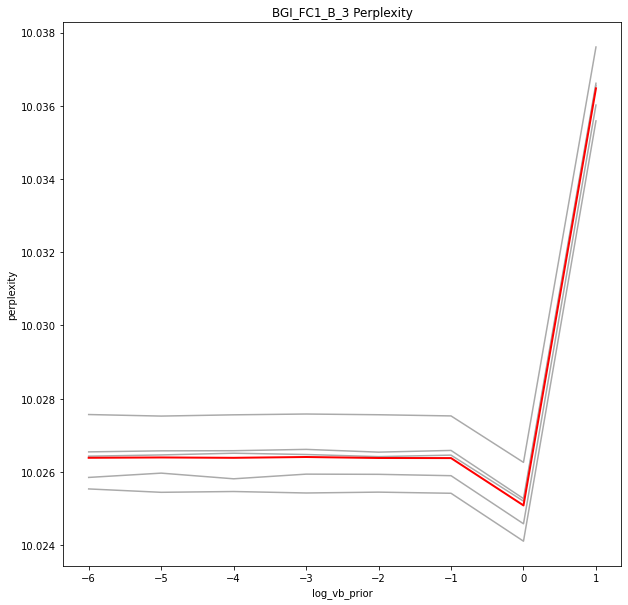

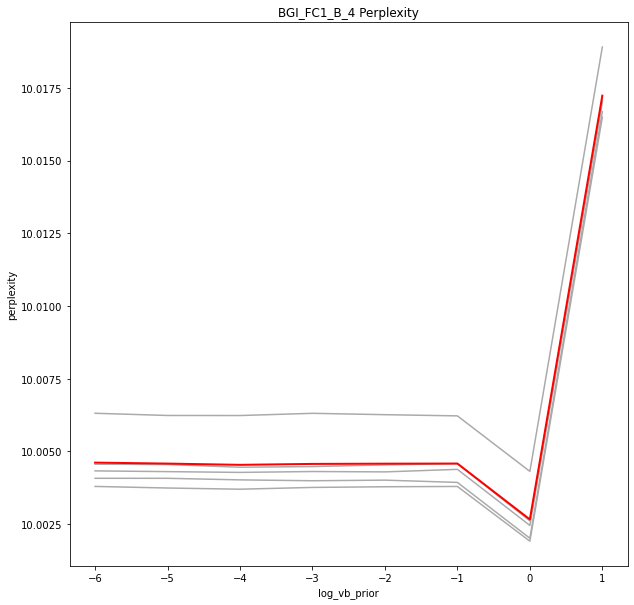

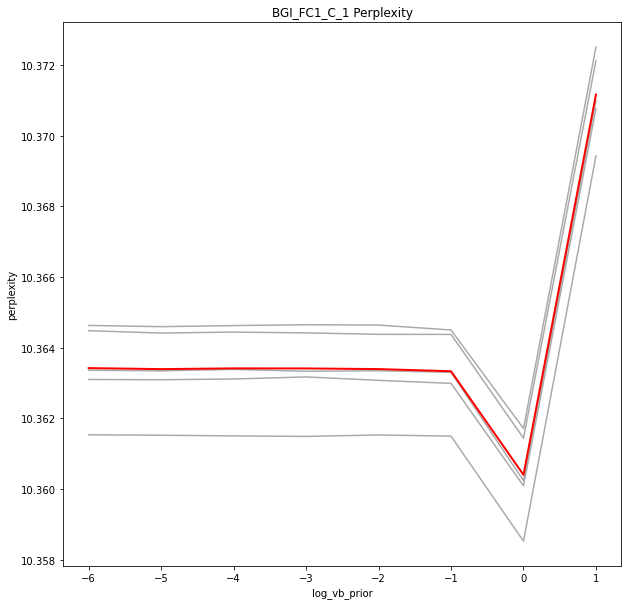

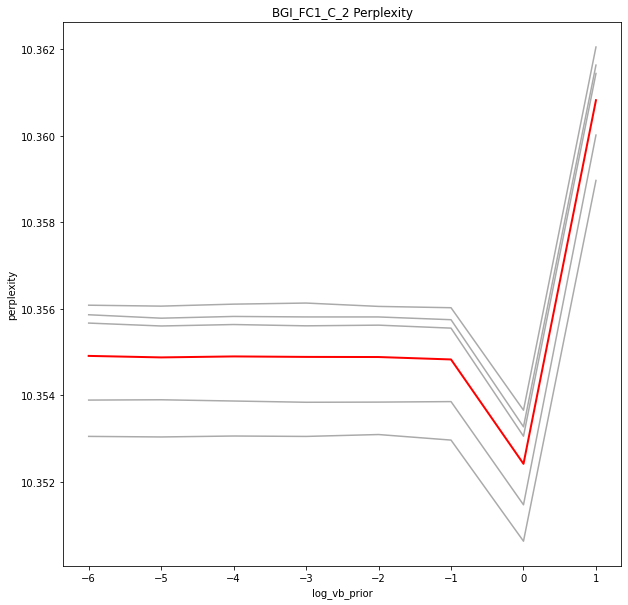

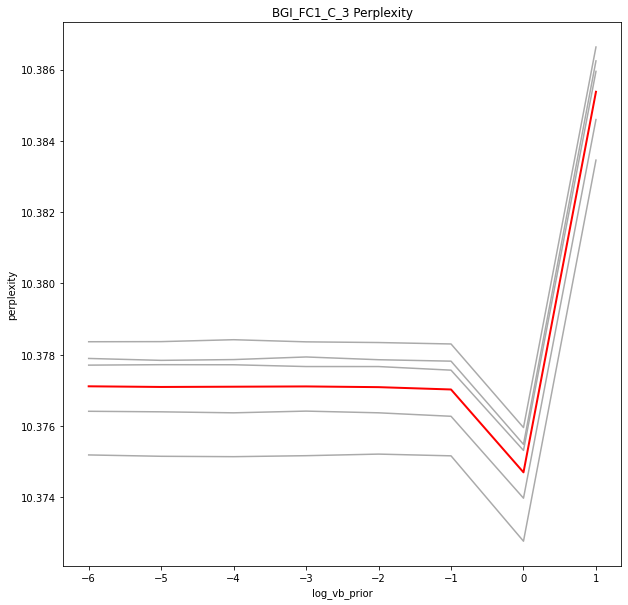

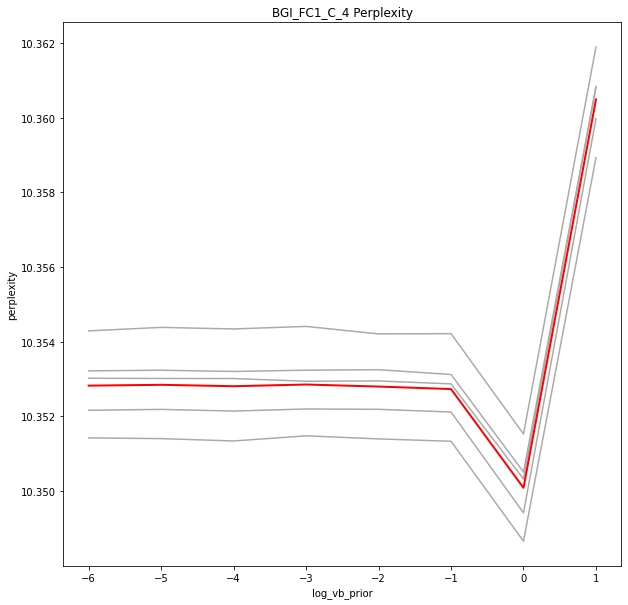

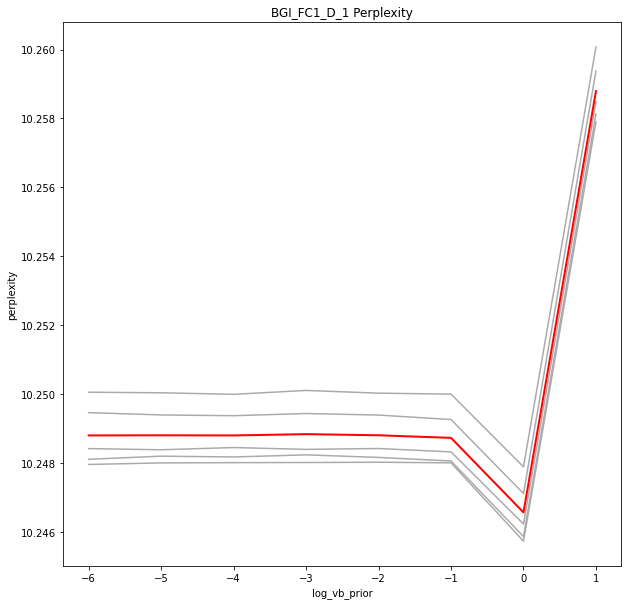

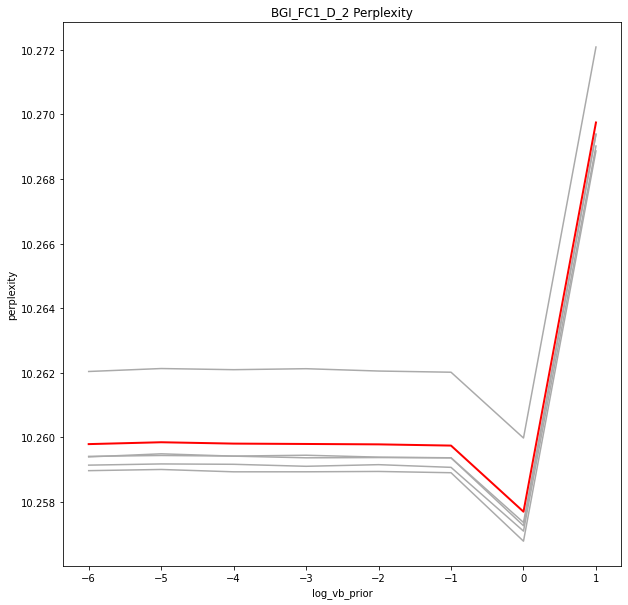

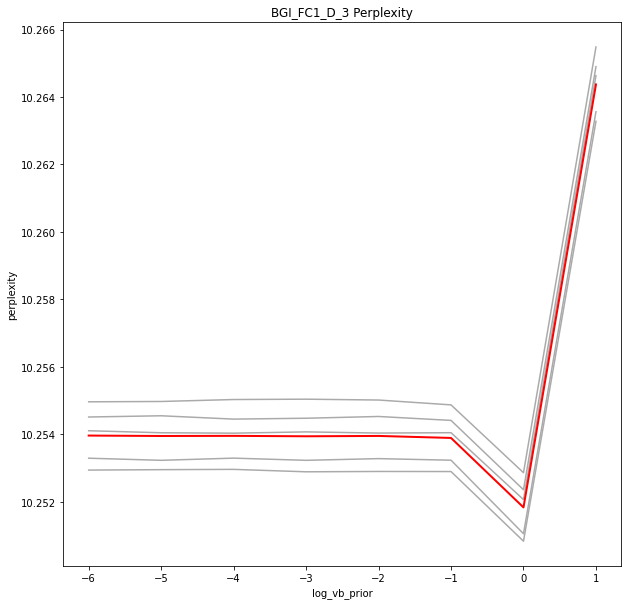

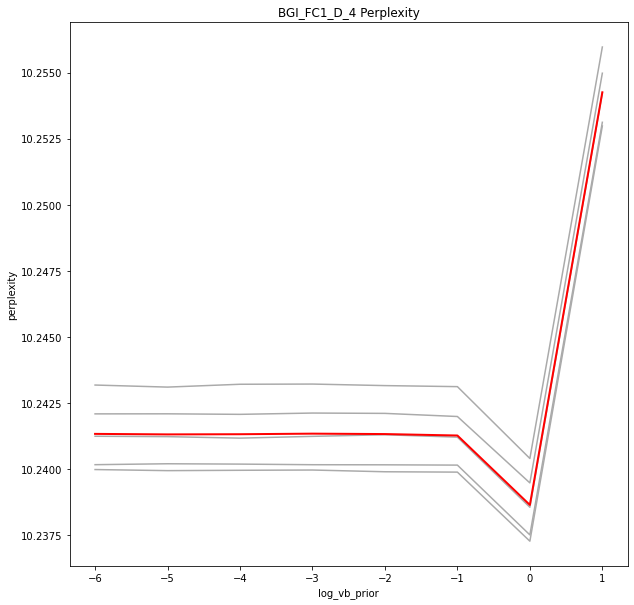

In [26]:
for sample in SAMPLES:
    perplexity_plot(sample, VB_PRIORS, 5)

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 30.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


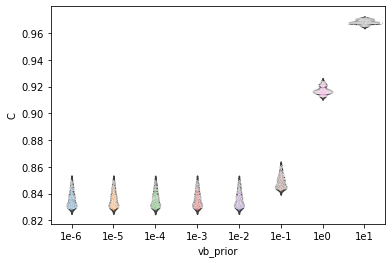

In [16]:
def arr_pearson(A, B):
    return pearsonr(A, B)[0]
pearson_res_df = pd.DataFrame()
for vbprior in VB_PRIORS:
    vbprior_df = pd.DataFrame(concordance(vbprior, comp_fn=arr_pearson))
    pearson_res_df = res_df.append(vbprior_df)

ax = sns.violinplot(x="vb_prior", y="C", data=res_df, inner=None)
ax = sns.swarmplot(x="vb_prior", y="C", data=res_df,
                   color="white", edgecolor="gray", dodge=True, s=1)

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'SEQC pearson (C)')

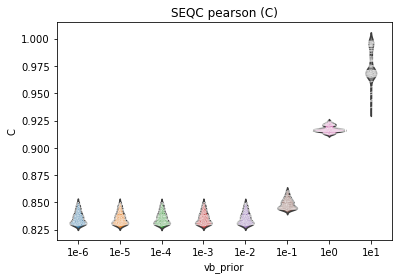

In [17]:
ax = sns.violinplot(x="vb_prior", y="C", data=pearson_res_df, inner=None)
ax = sns.swarmplot(x="vb_prior", y="C", data=pearson_res_df,
                   color="white", edgecolor="gray", dodge=True, s=1)
ax.set_title('SEQC pearson (C)')

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.6% of the points cannot be p

Text(0.5, 1.0, 'SEQC pearson (D)')

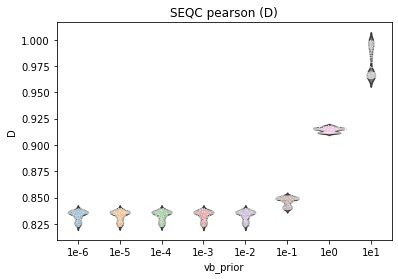

In [18]:
ax = sns.violinplot(x="vb_prior", y="D", data=pearson_res_df, inner=None)
ax = sns.swarmplot(x="vb_prior", y="D", data=pearson_res_df,
                   color="white", edgecolor="gray", dodge=True, s=1)
ax.set_title('SEQC pearson (D)')

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 30.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'SEQC spearman (C)')

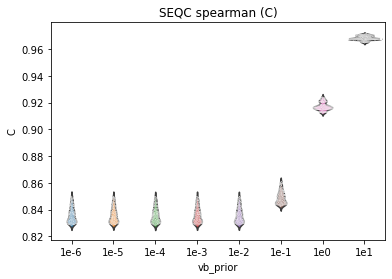

In [19]:
ax = sns.violinplot(x="vb_prior", y="C", data=res_df, inner=None)
ax = sns.swarmplot(x="vb_prior", y="C", data=res_df,
                   color="white", edgecolor="gray", dodge=True, s=1)
ax.set_title('SEQC spearman (C)')

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/shoal-experiments/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be place

Text(0.5, 1.0, 'SEQC spearman (D)')

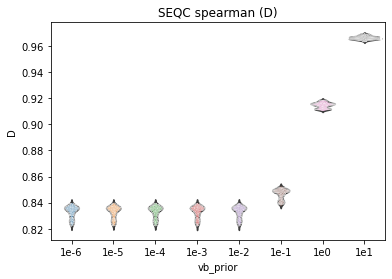

In [20]:
ax = sns.violinplot(x="vb_prior", y="D", data=res_df, inner=None)
ax = sns.swarmplot(x="vb_prior", y="D", data=res_df,
                   color="white", edgecolor="gray", dodge=True, s=1)
ax.set_title('SEQC spearman (D)')

In [21]:
def perplexity_votes(sample, vb_priors, folds):
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        #folds_rhos = []
        for fold in range(1, folds + 1):
            with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior, fold=fold), 'r') as f:
                perp_result = yaml.safe_load(f)
            #folds_rhos.append(rho)
            _vb_prior = float(vb_prior)
            df = df.append(dict(perplexity=-perp_result['smoothed_perplexity'],
                                vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior),
                                fold=fold), 
                           ignore_index=True)
    df = df.groupby('vb_prior').mean().reset_index()
    df['ranks'] = df.perplexity.rank()
    
    return df.groupby('vb_prior').mean().reset_index()
perplexity_votes(SAMPLES[0], VB_PRIORS, 5)

,vb_prior,fold,log_vb_prior,perplexity,ranks
0,0.000001,3.0,-6.0,10.315945,3.0
1,0.000010,3.0,-5.0,10.315930,2.0
2,0.000100,3.0,-4.0,10.316000,4.0
3,0.001000,3.0,-3.0,10.316072,6.0
4,0.010000,3.0,-2.0,10.316088,7.0
5,0.100000,3.0,-1.0,10.316005,5.0
6,1.000000,3.0,0.0,10.315532,1.0
7,10.000000,3.0,1.0,10.325643,8.0


In [22]:
rank_df = pd.DataFrame()
for sample in SAMPLES:
    _df = perplexity_votes(sample, VB_PRIORS, 5)
    rank_df = rank_df.append(_df, ignore_index=True)
    print(sample)
    print(_df)

BGI_FC1_A_1
    vb_prior  fold  log_vb_prior  perplexity  ranks
0   0.000001   3.0          -6.0   10.315945    3.0
1   0.000010   3.0          -5.0   10.315930    2.0
2   0.000100   3.0          -4.0   10.316000    4.0
3   0.001000   3.0          -3.0   10.316072    6.0
4   0.010000   3.0          -2.0   10.316088    7.0
5   0.100000   3.0          -1.0   10.316005    5.0
6   1.000000   3.0           0.0   10.315532    1.0
7  10.000000   3.0           1.0   10.325643    8.0
BGI_FC1_A_2
    vb_prior  fold  log_vb_prior  perplexity  ranks
0   0.000001   3.0          -6.0   10.305206    7.0
1   0.000010   3.0          -5.0   10.305190    3.0
2   0.000100   3.0          -4.0   10.305196    4.0
3   0.001000   3.0          -3.0   10.305201    5.0
4   0.010000   3.0          -2.0   10.305202    6.0
5   0.100000   3.0          -1.0   10.305170    2.0
6   1.000000   3.0           0.0   10.304829    1.0
7  10.000000   3.0           1.0   10.317216    8.0
BGI_FC1_A_3
    vb_prior  fold  log_vb_p

In [23]:
rank_df.groupby('vb_prior').mean().reset_index()

,vb_prior,fold,log_vb_prior,perplexity,ranks
0,0.000001,3.0,-6.0,10.242650,4.0000
1,0.000010,3.0,-5.0,10.242649,3.5625
2,0.000100,3.0,-4.0,10.242654,3.3750
3,0.001000,3.0,-3.0,10.242666,4.5625
4,0.010000,3.0,-2.0,10.242655,4.2500
5,0.100000,3.0,-1.0,10.242655,4.2500
6,1.000000,3.0,0.0,10.242741,4.0000
7,10.000000,3.0,1.0,10.255135,8.0000
